# Example of sampling parameters

## Model description

Impulse response models and parameter sampling
based on Tsutsui (2022, https://doi.org/10.5194/gmd-15-951-2022)

The MCE model is essentially built on impulse response functions for the fraction of the total CO<sub>2</sub> emitted that remains in the atmosphere (termed the airborne fraction), the decay of land carbon accumulated by the CO<sub>2</sub> fertilization effect, and temperature change to radiative forcing of CO<sub>2</sub> and other forcing agents. Under the linear response assumption with regard to input forcing $F$, an impulse response model (IRM) expresses the time change of a response variable $x$ by a convolution integral:
$$
x(t) = \int_{0}^{t} F(t^{'}) \sum_{i} A_{i}
\exp\left( -\frac{t-t'}{\tau_{i}}\right) dt^{'},
$$
where $t$ is time, and the sum of exponentials is an impulse response function with parameters $A_i$ and $\tau_i$ denoting the $i$-th component of the response amplitude and time constant, respectively. The time derivative of this equation is given by:
$$
\frac{dx(t)}{dt} = \sum_{i}
\left[ F(t) A_{i} - \frac{x_{i}(t)}{\tau_{i}} \right],
$$
or an equivalent box model form that is converted into the original IRM through Laplace transform or eigenfunction expansion. The time derivative implemented in the MCE uses an IRM form for land carbon decay and temperature change, and a box model form for the airborne fraction, to address partitioning of excess carbon between the atmosphere and ocean mixed layer.

There are a number of uncertain parameters, not only for the IRM amplitudes and time constants, but also for several control parameters used in forcing terms. To deal with these uncertainties, probabilistic runs are conducted with an ensemble of perturbed model parameters designed to encompass the variation of multiple CMIP models with additional constraints with regard to key indicators.

In general, a series of candidate values of an uncertain parameter is generated from its statistical model and, if necessary, sampled from the series with an acceptance algorithm for given constraints. The latter process is Bayesian updating from a prior probability distribution to a posterior and here uses a Metropolis-Hastings (MH) independence sampler.

In [1]:
import warnings
from io import StringIO
import yaml
import textwrap
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.stats
from netCDF4 import Dataset
from tqdm.notebook import tqdm
from mce import MCECalibError, MCEExecError
from mce.core.genparms import PcaParmsCmip
from mce.core.driver import Driver
from mce.util.io import retrieve_url
from mce.util.stat import StatModel, SamplingMH
from mce.util.plot_base import PlotBase

In [2]:
# Parameter attributes: long_name and units
with open('mce/core/attributes.yml') as f1:
    atts = yaml.safe_load(f1)

In [3]:
class DocParms:
    def __init__(self, atts):
        """Manipulation of parameter attributes

        Parameters
        ----------
        atts
            Definition of parameter attributes
        """
        self.atts = atts

    def _mkdesc(self, cat, name, att):
        return '{}|{}: {} ({})'.format(
            cat, name, att['long_name'], att['units'],
        )
        
    def desc(self, *args, **kw):
        cats = kw.get('cats', list(self.atts))
        if isinstance(cats, str):
            cats = [cats]

        for name in args:
            cats_found = []

            for cat, atts_cat in self.atts.items():
                if cat not in cats:
                    continue

                if name in atts_cat:
                    cats_found.append(cat)

            if len(cats_found) > 0:
                for cat in cats_found:
                    print(self._mkdesc(cat, name, self.atts[cat][name]))
            else:
                print(f'{name} not defined')

    def __call__(self, *args, **kw):
        self.desc(*args, **kw)

doc_parms = DocParms(atts['parameters'])

In [5]:
# Plotting module
myplt = PlotBase()

In [6]:
# Sampling size
nsize = 2000

# Fixed random seed setting for reproduction
seed_climate = 1
seed_ocean = 11
seed_land = 21

## 1. Sampling

### 1.1 Climate and CO2 forcing parameters

The temperature response parameters are synthetically generated with CO<sub>2</sub> forcing parameters from a multivariate normal distribution, built on principal components (PCs) of diagnosed parameters for each of the CMIP models.

In the standard configuration, the IRM of the temperature change defines three components with typical time constants of approximately 1, 10, and > 100 years. The response amplitude is rewritten by $\tilde{A}_i/(\lambda \tau_i)$, where $\tilde{A}_i$ is normalized so that the component sum is unity, and $\lambda$ is the climate feedback parameter in W/m<sup>2</sup>/degC, defined as the derivative of the outgoing thermal flux with respect to temperature change.

CO<sub>2</sub> forcing is evaluated with the following quadratic formula, in terms of the logarithm of CO<sub>2</sub> concentration:
$$
F_{\mathrm{C}}(x) = (\beta_{\mathrm{C}} - 1)
[\hat{F}_{\mathrm{C}}(x) - 2F_{\mathrm{C}}(2)]
[2\hat{F}_{\mathrm{C}}(x)/F_{\mathrm{C}}(2) - 1]
+ \beta_{\mathrm{C}} \hat{F}_{\mathrm{C}}(x)
$$
$$
\hat{F}_{\mathrm{C}}(x) = \alpha_{\mathrm{C}}
\ln [\mathrm{CO_{2}(t)/\mathrm{CO_{2}(0)}}],
$$
where $x$ is the ratio of CO<sub>2</sub> concentrations to a preindustrial level, $\alpha_{\mathrm{C}}$ is a scaling parameter in W/m<sup>2</sup>, and $\beta_{\mathrm{C}}$ is an amplification factor defined as $F_{\mathrm{C}}(4) = \beta_{\mathrm{C}} \times \hat{F}_{\mathrm{C}}(4)$.

The quadratic term is activated when the concentration exceeds a two-times level ($x>2$), and $\beta_{\mathrm{C}}$ is set to unity in the range $x \le 2$ so that $F_{\mathrm{C}}$ is equivalent to $\hat{F}_{\mathrm{C}}$. The forcing amplification is expected to be valid in the range $x \le 4$ and the quadratic term is dropped beyond a four-time level.

In [7]:
# Parameters calibrated to CMIP5 and CMIP6 models
use_new_data = False

if use_new_data:
    outpath = 'data/parms_calib_climate.h5'
    with pd.HDFStore(outpath, 'r') as store:
        df = (
            store['cmip_norm1__nl3'] # 3-layer model
            .sort_index(key=lambda x: x.str.lower())
        )
        df['ecs_reg'] = 0.5 * df['q4x_reg'] / df['lambda_reg']

else:

    df = {}

    with Dataset('mce/data/parms/parms_irm-3_rtnt-tas_cmip5.nc') as ncf:
        df['CMIP5'] = pd.DataFrame({
            k: v[:].filled()
            for k, v in ncf.variables.items() if k not in ['dataset']
        }, index=[
            ''.join(x.astype(str)).strip()
            for x in ncf.variables['dataset'][:]
        ])

    with Dataset('mce/data/parms/parms_irm-3_rtnt-tas_cmip6.nc') as ncf:
        df['CMIP6'] = pd.DataFrame({
            k: v[:].filled()
            for k, v in ncf.variables.items() if k not in ['dataset']
        }, index=[
            ''.join(x.astype(str)).strip()
            for x in ncf.variables['dataset'][:]
        ])
    df = pd.concat(df).rename(
        columns={
            'alpha': 'co2_alpha',
            'beta': 'co2_beta',
            'time_constant_0': 'tau0',
            'time_constant_1': 'tau1',
            'time_constant_2': 'tau2',
            'amplitude_0': 'a0',
            'amplitude_1': 'a1',
            'amplitude_2': 'a2',
        }
    ).rename_axis(['mip', 'dataset']).sort_index(key=lambda x: x.str.lower())

df_parms_cmip = df

In [8]:
df_parms_cmip

tau0        a0       tau1  lambda_reg   tcr_gcm  \
mip   dataset                                                            
CMIP5 ACCESS1.0    1.770429  0.309628  11.857424    0.777060  1.921747   
      ACCESS1.3    1.085171  0.183242   7.639266    0.819500  1.631630   
      BCC-CSM1.1   1.676995  0.349606   9.769733    1.137433  1.736432   
      BNU-ESM      1.253887  0.288810   9.062490    0.966931  2.490674   
      CanESM2      2.171483  0.447780  21.435611    1.038722  2.340212   
...                     ...       ...        ...         ...       ...   
CMIP6 NESM3        0.688722  0.383838  18.372645    0.801938  2.709527   
      NorESM2-LM   0.043158  0.071591   1.821879    1.380486  1.475827   
      NorESM2-MM   0.066863  0.146193   2.321184    1.472066  1.335450   
      SAM0-UNICON  0.349018  0.079816   3.996651    1.048148  2.264424   
      UKESM1-0-LL  1.464433  0.264797  18.546190    0.679551  2.786460   

                    ecs_reg        a2        a1  co2_beta    lambda  \
mip   dataset                                                         
CMIP5 ACCESS1.0    3.827931  0.503922  0.186450  1.019410  0.784780   
      ACCESS1.3    3.531926  0.505497  0.311261  1.075596  0.834141   
      BCC-CSM1.1   2.826381  0.371607  0.278788  1.037867  1.130386   
      BNU-ESM      3.923890  0.361799  0.349391  1.007903  0.970174   
      CanESM2      3.691430  0.329360  0.222860  1.018086  1.018417   
...                     ...       ...       ...       ...       ...   
CMIP6 NESM3        4.715919  0.346096  0.270066  1.048372  0.870825   
      NorESM2-LM   2.536783  0.409216  0.519193  1.178675  1.285466   
      NorESM2-MM   2.498568  0.370381  0.483427  1.211972  1.428417   
      SAM0-UNICON  3.716904  0.448376  0.471808  1.006970  0.958230   
      UKESM1-0-LL  5.337168  0.426639  0.308563  1.006066  0.681362   

                         tau2       ecs  co2_alpha       tcr  
mip   dataset                                                 
CMIP5 ACCESS1.0    219.715468  3.750815   4.246666  1.982800  
      ACCESS1.3    255.390396  3.261574   3.925013  1.697960  
      BCC-CSM1.1   141.681350  2.729098   4.450617  1.798378  
      BNU-ESM      291.686972  3.896504   5.453803  2.445168  
      CanESM2      261.563893  3.642714   5.352112  2.298461  
...                       ...       ...        ...       ...  
CMIP6 NESM3        411.292266  4.434479   5.571190  2.697093  
      NorESM2-LM   228.466186  2.194624   4.070008  1.390649  
      NorESM2-MM   217.483061  2.084728   4.296145  1.390161  
      SAM0-UNICON  265.279760  3.799744   5.252893  2.196989  
      UKESM1-0-LL  317.829576  5.313040   5.222703  2.821658  

[63 rows x 14 columns]

In [9]:
doc_parms(
    *sorted(df_parms_cmip),
    **{'cats': ['forcing', 'climate']},
)

climate|a0: Fraction of the first time constant contribution to the surface temperature change (no_unit)
climate|a1: Fraction of the second time constant contribution to the surface temperature change (no_unit)
climate|a2: Fraction of the third time constant contribution to the surface temperature change (no_unit)
forcing|co2_alpha: Scaling factor of CO2 forcing (W m-2)
forcing|co2_beta: Amplification factor of CO2 forcing (no_unit)
climate|ecs: Equilibrium climate sensitivity (K)
climate|ecs_reg: Equilibrium climate sensitivity based on conventional linear regression (K)
climate|lambda: Climate feedback parameter (W m-2 K-1)
climate|lambda_reg: Climate feedback parameter based on conventional linear regression (W m-2 K-1)
climate|tau0: First (shortest) time constant (y)
climate|tau1: Second time constant (y)
climate|tau2: Third time constant (y)
climate|tcr: Transient climate response (K)
climate|tcr_gcm: Transient climate response by GCM data (K)


In [10]:
# Eight independent parameters to be fed into PC analysis

# Selected parameters:
names0 = [
    'tcr', 'co2_alpha', 'co2_beta', 'tau0', 'tau1', 'tau2', 'a0', 'a1', 'a2',
]

# Used parameters:
names = [
    'tcr', 'co2_alpha', 'co2_beta', 'tau0', 'tau1', 'tau2', 'af0', 'af2',
]
# including two derived parameters: af0 and af2, defined as a0/a1 and a2/a1

# Those for which logarithmic transformation is applied for normality
# and ensuring positive values
names_log = [
    'co2_beta', 'tcr', 'tau0', 'tau1', 'tau2', 'af0', 'af2',
]

In [11]:
# Check outliers, here defined as exceeding three times the standard deviation
# of the ensemble for any of the selected parameters
outlier = (
    df_parms_cmip[names0]
    .apply(lambda x: np.abs(scipy.stats.zscore(x)) > 3)
    .any(axis=1)
)
df_parms_cmip[outlier]

,,tau0,a0,tau1,lambda_reg,tcr_gcm,ecs_reg,a2,a1,co2_beta,lambda,tau2,ecs,co2_alpha,tcr
mip,dataset,,,,,,,,,,,,,,
CMIP5,GFDL-CM3,2.763172,0.375364,45.017324,0.752759,1.951139,3.969521,0.363223,0.261413,1.027046,0.751565,396.681809,3.879747,4.206727,2.013614
CMIP6,ACCESS-CM2,2.164487,0.322753,37.497733,0.712565,2.106657,4.719159,0.293814,0.383433,1.125282,0.721581,3643.927675,4.186360,4.358092,2.196807


In [12]:
# Perform PC analysis
pc = PcaParmsCmip(names, names_log=names_log)
score = pc.analysis(df_parms_cmip.loc[np.logical_not(outlier)])

[2024-09-25 16:27:55 mce.core.genparms] INFO:ev0 reversed
[2024-09-25 16:27:55 mce.core.genparms] INFO:ev1 reversed
[2024-09-25 16:27:55 mce.core.genparms] INFO:ev2 reversed
[2024-09-25 16:27:55 mce.core.genparms] INFO:ev4 reversed
[2024-09-25 16:27:55 mce.core.genparms] INFO:ev5 reversed
[2024-09-25 16:27:55 mce.core.genparms] INFO:ev6 reversed
[2024-09-25 16:27:55 mce.core.genparms] INFO:ev7 reversed


In [13]:
# Sampling based on a multivariate normal distribution
df_parms_p_climate, score_p = pc.genparms(
    pc.eigval, nsize=nsize, seed=seed_climate,
)
df_parms_p_climate

,tcr,co2_alpha,co2_beta,tau0,tau1,tau2,a1,a2,a0,ecs,lambda,ecs_reg
0,2.075612,4.796599,1.005527,10.471274,19.083493,310.912678,0.314835,0.257410,0.427756,3.341485,0.994991,3.359952
1,1.954319,4.717010,1.093880,1.124190,9.657118,743.160184,0.364633,0.376572,0.258795,3.335868,0.980130,3.649039
2,1.958035,5.426690,1.009653,0.393548,5.331927,249.934387,0.340227,0.457565,0.202209,3.414284,1.101694,3.447243
3,1.911116,5.359108,1.045795,1.103090,12.355346,338.286040,0.274731,0.302020,0.423249,2.844808,1.305765,2.975087
4,1.585156,5.109208,1.004527,0.521930,3.920517,236.580841,0.386777,0.423439,0.189784,2.598539,1.362855,2.610304
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.729788,3.969826,1.047032,1.270481,9.393706,271.589857,0.296906,0.395917,0.307178,2.858370,0.962672,2.992804
1996,1.938918,3.908686,1.196239,1.101181,9.124298,333.458069,0.234522,0.556028,0.209450,4.176949,0.648630,4.996631
1997,2.093927,4.958263,1.114223,0.149591,5.791922,190.473323,0.389496,0.455208,0.155296,3.573068,0.961864,3.981193
1998,2.030559,5.308846,1.122465,3.724149,16.134448,283.732344,0.181115,0.323007,0.495877,3.144793,1.170128,3.529919


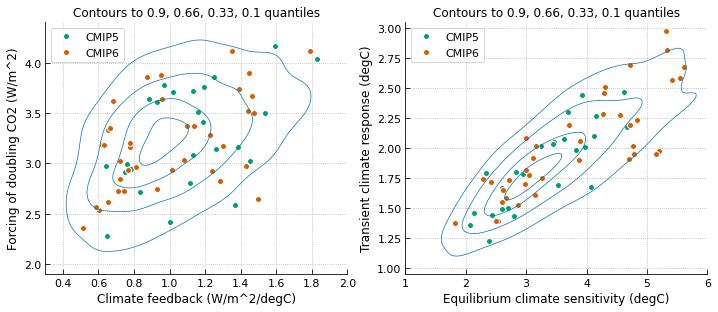

In [14]:
# Characteristic relationships associated with temperature response

df_parms_p = df_parms_p_climate.copy()

df_parms_cmip['erf|2xCO2'] = df_parms_cmip['co2_alpha'] * np.log(2)
df_parms_p['erf|2xCO2'] = df_parms_p['co2_alpha'] * np.log(2)

variables = {
    'lambda': ('Climate feedback', 'W/m^2/degC'),
    'ecs_reg': ('Equilibrium climate sensitivity', 'degC'),
    'tcr': ('Transient climate response', 'degC'),
    'erf|2xCO2': ('Forcing of doubling CO2', 'W/m^2'),
}

map_lim = {
    'ecs_reg': (1., 6.),
    'tcr': (0.95, 3.05),
    'lambda': (0.3, 2.),
    'erf|2xCO2': (1.9, 4.4),
}
map_colors = {
    'CMIP5': 'C2',
    'CMIP6': 'C3',
}
kw_plot_cmip = {'ls': 'None', 'marker': 'o', 'mec': 'w'}
prob_ref = np.array([0.90, 0.66, 0.33, 0.1])

myplt.init_regular(2, col=2, kw_space={'height': 3.5, 'aspect': 1.2})

for n, (xvar, yvar) in enumerate([('lambda', 'erf|2xCO2'), ('ecs_reg', 'tcr')]):
    ax = myplt(n)
    for mip, df in df_parms_cmip.groupby('mip'):
        ax.plot(
            df[xvar].values, df[yvar].values, color=map_colors[mip],
            label=mip.upper(), **kw_plot_cmip)

    ax.legend()

    xlim = map_lim[xvar]
    ylim = map_lim[yvar]
    xp, yp = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
    positions = np.vstack([xp.ravel(), yp.ravel()])

    din = df_parms_p.loc[:nsize, [xvar, yvar]].T.values
    pdf = scipy.stats.gaussian_kde(din)
    zp = pdf(positions).reshape(xp.shape)
    levels = np.quantile(pdf(din), 1.-prob_ref)
    ax.contour(xp, yp, zp, levels, colors='C0', linewidths=0.7)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.grid()
    ax.set_xlabel('{} ({})'.format(*variables[xvar]))
    ax.set_ylabel('{} ({})'.format(*variables[yvar]))
    ax.set_title(
        'Contours to {} quantiles'.format(
            ', '.join([f'{x}' for x in prob_ref])
        )
    )

del df_parms_p

### 1.2 Ocean carbon cycle

The IRM for the airborne fraction defines five components, one of which has infinity time constant, paired with an amplitude corresponding to an asymptotic long-term fraction. In the current configuration, the remaining four time constants are fixed at 236.5, 59.52, 12.17, and 1.271 years, adjusted to a specific three-dimensional ocean carbon cycle model in Hooss et al. (2001, http://dx.doi.org/10.1007/s003820100170). The corresponding amplitudes assume perturbations at reference values of 0.24, 0.21, 0.25, and 0.1, respectively, with a reference long-term airborne fraction of 0.20. These reference values and perturbation ranges are set empirically so that resulting carbon budgets&mdash;cumulative land and ocean CO<sub>2</sub> uptake&mdash;agree with those of historical observations and CMIP experiments.

The perturbations are generated with a uniform distribution for each of the amplitudes, except for the one corresponding to the shortest time constant. Since the sum of the amplitudes is unity, their perturbed values are normalized as such, subject to a modified distribution with more samples about the mean resulting from the operation.

In [15]:
# Dummy driver to use the ocean carbon cycle module
drv = Driver([0.], eco2=[0.])

In [16]:
# Reference amplitudes in terms of the airborne fraction
amp_ref = drv.ocean.parms.amp_ref
amp_ref

array([0.2 , 0.24, 0.21, 0.25, 0.1 ])

In [17]:
# amp parameters are perturbed
# except for amp4 corresponding to the shortest time constant
perturb_ocean = 0.05
amp = amp_ref[None, :] + np.zeros((nsize, len(amp_ref)))
np.random.seed(seed_ocean)
rnd = (np.random.rand(nsize, 4)/0.5 - 1.) * perturb_ocean
amp[:, :4] = amp[:, :4] + rnd
amp[:, :4] *= (amp_ref[:4].sum() / amp[:, :4].sum(axis=1)).reshape((-1, 1))
df_parms_p_ocean_irm = pd.DataFrame(amp).rename(columns=lambda x: f'amp{x}')

In [18]:
# tau parameters are fixed in this case
# tau0, not included, assumes infinity,
# corresponding to amp0, asymptotic long-term airborne fraction
df = pd.DataFrame(
    drv.ocean.parms.tau_ref.repeat(nsize).reshape((-1, nsize)).T,
).rename(columns=lambda j: 'tau{}'.format(j + 1))
df_parms_p_ocean_irm = pd.concat([df_parms_p_ocean_irm, df], axis=1)
df_parms_p_ocean_irm

,amp0,amp1,amp2,amp3,amp4,tau1,tau2,tau3,tau4
0,0.180289,0.205955,0.221378,0.292378,0.1,236.5,59.52,12.17,1.271
1,0.205595,0.255406,0.172679,0.266321,0.1,236.5,59.52,12.17,1.271
2,0.228175,0.257049,0.217724,0.197051,0.1,236.5,59.52,12.17,1.271
3,0.225639,0.259878,0.166370,0.248113,0.1,236.5,59.52,12.17,1.271
4,0.179785,0.238463,0.226595,0.255156,0.1,236.5,59.52,12.17,1.271
...,...,...,...,...,...,...,...,...,...
1995,0.167581,0.247610,0.215537,0.269271,0.1,236.5,59.52,12.17,1.271
1996,0.204884,0.278992,0.157707,0.258417,0.1,236.5,59.52,12.17,1.271
1997,0.152154,0.251674,0.235773,0.260399,0.1,236.5,59.52,12.17,1.271
1998,0.158295,0.276500,0.237916,0.227289,0.1,236.5,59.52,12.17,1.271


In [20]:
doc_parms(
    *df_parms_p_ocean_irm.columns.to_list(),
    **{'cats': 'ocean'},
)

ocean|amp0: Asymptotic long-term airborne fraction (no_unit)
ocean|amp1: Airborne fraction corresponding to the first time constant (no_unit)
ocean|amp2: Airborne fraction corresponding to the second time constant (no_unit)
ocean|amp3: Airborne fraction corresponding to the third time constant (no_unit)
ocean|amp4: Airborne fraction corresponding to the fourth time constant (no_unit)
ocean|tau1: First (finite and longest) component of time constants (y)
ocean|tau2: Second component of time constants (y)
ocean|tau3: Third component of time constants (y)
ocean|tau4: Fourth (shortest) component of time constants (y)


The box model converted from the IRM for the airborne fraction is as follows:
$$
\frac{d c_{0}}{d t} = - \frac{\eta_{1}}{h_{s}} c_{s} + \frac{\eta_{1}}{h_{1}} c_{1} + e - f,
$$
$$
\frac{d c_{1}}{d t} = \frac{\eta_{1}}{h_{s}} c_{s} - \frac{\eta_{1} + \eta_{2}}{h_{1}} c_{1} + \frac{\eta_{2}}{h_{2}} c_{2},
$$
$$
\frac{d c_{2}}{d t} = \frac{\eta_{2}}{h_{1}} c_{1} - \frac{\eta_{2} + \eta_{3}}{h_{2}} c_{2} + \frac{\eta_{3}}{h_{3}} c_{3},
$$
$$
\frac{d c_{3}}{d t} = \frac{\eta_{3}}{h_{2}} c_{2} - \frac{\eta_{3}}{h_{3}} c_{3},
$$
where $c_k$ is the amount of excess carbon in layer $k$, $h_k$ is the layer depth, $\eta_k$ is the exchange coefficient between layer $k-1$ and layer $k$, $e$ is anthropogenic emissions, and $f$ is natural uptake over land. The parameters $h_k$ and $\eta_k$ are set through numerical optimization for the box model to be equivalent to the IRM form.

The top layer, indexed with "0," is the composite atmosphere-ocean mixed layer, and the three sub-surface layers are indexed with "1," "2," and "3" in the order of ocean depth. The amount of excess carbon in the top layer ($c_0$) is partitioned into atmospheric and ocean components, denoted by $c_a$ and $c_s$, subject to chemical equilibrium at the ocean surface. The carbon exchange between the top layer and the first sub-surface is expressed in terms of $c_s$.

The box model parameters depend on pre-industrial CO<sub>2</sub> concentrations. Here, numerical optimization is conducted to have the box-model parameters calibrated with 1750 and 1850 levels. Historical CO<sub>2</sub> concentrations can be looked up from RCMIP time series.

In [21]:
fn = 'rcmip-concentrations-annual-means-v5-1-0.csv'
path = retrieve_url(
    f'./datain/rcmip/{fn}',
    f'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/{fn}',
)

df = pd.read_csv(path)
df_rcmip_conc = (
    df
    .set_index(df.columns[:7].to_list())
    .rename(columns=int)
)

[2024-09-25 16:34:38 mce.util.io] INFO:Use local file datain/rcmip/rcmip-concentrations-annual-means-v5-1-0.csv retrieved from https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-concentrations-annual-means-v5-1-0.csv on 2024-06-20


In [22]:
d_cco2_hist = df_rcmip_conc.groupby(
    ['Scenario', 'Region', 'Variable']
).get_group(
    ('historical', 'World', 'Atmospheric Concentrations|CO2')
).squeeze().dropna()
d_cco2_hist

1700    276.746000
1701    276.749995
1702    276.757998
1703    276.757001
1704    276.755000
           ...    
2010    388.717031
2011    390.944021
2012    393.015991
2013    395.724978
2014    397.546979
Name: (unspecified, historical, World, Atmospheric Concentrations|CO2, ppm, input4MIPs, CMIP6), Length: 315, dtype: float64

In [23]:
# Initial values candidates
x0_base = np.array([1000., 1000., 10., 10., 10.])
mi = pd.MultiIndex.from_product([np.array([0.1, 1., 10.])] * 5)
df_x0 = pd.DataFrame(
    [np.array(factor) * x0_base for factor in mi], index=mi,
    columns=['hl2', 'hl3', 'eta1', 'eta2', 'eta3']
).sort_index(key=lambda x: np.fabs(np.log10(x)))
# h0 is determined by a given pre-industrial CO2 concentration
# h1 is derived from the other parameters
df_x0

hl2      hl3   eta1   eta2   eta3
1.0  1.0  1.0  1.0  1.0    1000.0   1000.0   10.0   10.0   10.0
                    0.1    1000.0   1000.0   10.0   10.0    1.0
                    10.0   1000.0   1000.0   10.0   10.0  100.0
               0.1  1.0    1000.0   1000.0   10.0    1.0   10.0
               10.0 1.0    1000.0   1000.0   10.0  100.0   10.0
...                           ...      ...    ...    ...    ...
10.0 10.0 0.1  10.0 10.0  10000.0  10000.0    1.0  100.0  100.0
          10.0 0.1  0.1   10000.0  10000.0  100.0    1.0    1.0
                    10.0  10000.0  10000.0  100.0    1.0  100.0
               10.0 0.1   10000.0  10000.0  100.0  100.0    1.0
                    10.0  10000.0  10000.0  100.0  100.0  100.0

[243 rows x 5 columns]

In [24]:
# Conduct optimization to solve the box model parameters

names_amp = [f'amp{j}' for j in range(0, 5)]
names_tau = [f'tau{j}' for j in range(1, 5)]
df_parms_p_ocean = {}

for year in tqdm([1750, 1850], leave=False):
    cco2_pi = d_cco2_hist.loc[year]
    # Update pre-industrial CO2-dependent parameters,
    # including the atmospheric thickness (hla)
    drv.ocean.update_pi(cco2_pi)

    dfout = df_parms_p_ocean.setdefault(year, [])

    for k, v in tqdm(
        df_parms_p_ocean_irm.iterrows(), total=nsize, leave=False,
        ):
        # Combined atmosphere-ocean mixed layer thickness
        hl0 = drv.ocean.parms.hla / (1. - v['amp4'])

        # Filter out unexpected initial values candidates
        dfin = df_x0
        dfin = dfin.loc[dfin['hl3'] <= hl0 * (1. / v['amp0'] - 1.)]
        dfin = dfin.loc[dfin['hl2'] <= hl0 * (1. / v['amp0'] - 1.)]
        dfin = dfin.loc[
            dfin['hl2'] <= hl0 * (1. / v['amp0'] - 1.) - dfin['hl3']
        ]

        for _, x0 in dfin.iterrows():
            try:
                hlk, etak = drv.ocean._calib(
                    tau=v[names_tau], amp=v[names_amp], x0=x0,
                )
            except MCECalibError as e:
                continue

            break

        else:
            raise MCEExecError('Calibration not successful')

        dfout.append(np.hstack([hlk, etak]))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [25]:
columns = (
    ['hls']
    + [f'hl{j}' for j in range(1, 4)]
    + [f'eta{j}' for j in range(1, 4)]
)
df_parms_p_ocean = pd.concat({
    k: pd.DataFrame(v, columns=columns)
    for k, v in df_parms_p_ocean.items()
})
df_parms_p_ocean

hls         hl1          hl2          hl3       eta1  \
1750 0     70.394507  566.524394  1024.744396  1218.876197  22.381354   
     1     70.394507  472.179736   809.018846  1096.409559  20.230219   
     2     70.394507  376.979061   754.232331   941.438379  16.375691   
     3     70.394507  430.285744   726.845425   946.724018  18.991886   
     4     70.394507  493.973251   990.322817  1335.689144  20.165164   
...              ...         ...          ...          ...        ...   
1850 1995  72.752653  534.561172  1071.106775  1574.007637  21.659322   
     1996  72.752653  463.174332   817.027891  1188.105745  20.260206   
     1997  72.752653  535.680702  1181.533042  1858.626314  21.358729   
     1998  72.752653  471.273084  1103.524280  1834.099823  19.273454   
     1999  72.752653  441.635207  1058.531968  1839.977931  18.322545   

               eta2      eta3  
1750 0     8.921807  4.143772  
     1     6.842462  4.034691  
     2     7.139665  3.388273  
     3     6.284568  3.630503  
     4     8.558103  4.415025  
...             ...       ...  
1850 1995  8.888736  5.088039  
     1996  6.625851  4.450726  
     1997  9.644340  5.635752  
     1998  9.170183  5.540885  
     1999  8.799080  5.570260  

[4000 rows x 7 columns]

In [26]:
doc_parms(
    *df_parms_p_ocean.columns.to_list(),
    **{'cats': 'ocean'},
)

ocean|hls: Surface mixed layer depth (m)
ocean|hl1: Sub-surface layer 1 depth (m)
ocean|hl2: Sub-surface layer 2 depth (m)
ocean|hl3: Sub-surface layer 3 depth (m)
ocean|eta1: Exchange coefficient between the surface and layer 1 (m y-1)
ocean|eta2: Exchange coefficient between the sub-surface layers 1 and 2 (m y-1)
ocean|eta3: Exchange coefficient between the sub-surface layers 2 and 3 (m y-1)


### 1.3 Land carbon cycle

The IRM for land carbon defines four carbon pools, representing ground vegetation, wood, detritus, and soil organic carbon, with distinct overturning times ($\tau_{i}$). The forcing term ($F$) is net primary production (NPP) enhanced by the effect of CO<sub>2</sub> fertilization, generally expressed by $\beta_{L} N_{0}$, where $\beta_{L}$ is a fertilization factor that depends on the atmospheric CO<sub>2</sub> concentration, and $N_{0}$ is base annual NPP in GtC per year.

The response amplitude ($A_{i}$) is rewritten as $\tilde{A}_{bi} \tau_{i}$, where $\tilde{A}_{bi}$ denotes a decay flux after an initial carbon input. Based on Joos et al. (1996, https://doi.org/10.3402/tellusb.v48i3.15921), the IRM parameters of the four carbon pools are set to 2.9, 20, 2.2, and 100 years for $\tau_{i}$, and 0.70211, 0.013414, &minus;0.71846, and 0.0029323 years<sup>&minus;1</sup> for $\tilde{A}_{bi}$, respectively.

The MCE deals with temperature dependency for the time constants of wood and soil organic carbon, indicating the tendency for warming to accelerate the decomposition of organic matter. This is one of the climate-carbon cycle feedback processes and is implemented with an adjustment coefficient varied along a logistic curve with respect to surface warming. This scheme has a parameter to control the asymptotic minimum value of the coefficient.

The land carbon uptake term $f$ in the above box model form is calculated from the time derivative of the IRM formula, rewritten as:
$$
f(t) = \sum_{i} \left[
\beta_{L}(t) N_{0} \tilde{A}_{bi} \tau_{i} - \frac{c_{bi}}{\tau_{i}} \right],
$$
where $c_{bi}$ is the $i$-th component of accumulated carbon by CO<sub>2</sub> fertilization. The base NPP ($N_{0}$) is set to 60 GtC/yr and the fertilization factor ($\beta_{L}$) is formulated with a sigmoid curve with regard to CO<sub>2</sub> concentration, as described in Meinshausen et al. (2011, https://doi.org/10.5194/acp-11-1417-2011). This implementation is connected to a conventional logarithmic formula:
$$
\beta_{L} = 1 + \hat{\beta}_{L} \ln [\mathrm{CO_{2}(t)/\mathrm{CO_{2}(0)}}],
$$
such that the sigmoid and logarithmic curves are equal in terms of an increase ratio at 680 ppm relative to 340 ppm, and the latter factor $\hat{\beta}_{L}$ is used as a control parameter.

Here, the two control parameters for land carbon decay timescales and CO<sub>2</sub> fertilization are selected as those to be perturbed. Perturbation is based on a uniform distribution around a given reference value with a given uncertainty range.

In [27]:
beta_ref = 0.43
perturb_land_beta = 0.30
fb_alpha_ref = 0.87
perturb_land_fb_alpha = 0.13

np.random.seed(seed_land)
rnd = np.random.rand(2*nsize)/0.5 - 1.

df_parms_p_land = pd.DataFrame([
    beta_ref + rnd[:nsize] * perturb_land_beta, 
    fb_alpha_ref + rnd[nsize:] * perturb_land_fb_alpha,
], index=['beta', 'fb_alpha']).T
df_parms_p_land

,beta,fb_alpha
0,0.159235,0.972120
1,0.303466,0.932916
2,0.562580,0.984677
3,0.142970,0.955566
4,0.253554,0.816463
...,...,...
1995,0.560609,0.902525
1996,0.580905,0.977000
1997,0.321661,0.897656
1998,0.168108,0.995761


In [28]:
doc_parms(
    *df_parms_p_land.columns.to_list(),
    **{'cats': 'land'},
)

land|beta: Control parameter of CO2 fertilization effect (no_unit)
land|fb_alpha: Control parameter to adjust land carbon overturning times (no_unit)


In [34]:
# Save the generated parameter ensemble
outpath = 'untracked/parms_perturbed_model.h5'
df_parms_p_climate.to_hdf(outpath, 'parms_p_climate')
df_parms_p_ocean_irm.to_hdf(outpath, 'parms_p_ocean_irm')
d_cco2_hist.loc[[1750, 1850]].to_hdf(outpath, 'cco2_pi')
df_parms_p_ocean.to_hdf(outpath, 'parms_p_ocean')
df_parms_p_land.to_hdf(outpath, 'parms_p_land')

## 2. Ensemble runs

Conduct ensemble runs for a 1%-per-year increase trajectory of the atmospheric CO2 concentration
and compare carbon budget indicators.

In [29]:
d_cco2_1pct = df_rcmip_conc.groupby(
    ['Scenario', 'Region', 'Variable']
).get_group(
    ('1pctCO2', 'World', 'Atmospheric Concentrations|CO2')
).squeeze().dropna().loc[1850:2000]
d_cco2_1pct

1850     284.316999
1851     287.160169
1852     290.031770
1853     292.932088
1854     295.861409
           ...     
1996    1215.411660
1997    1227.565777
1998    1239.841434
1999    1252.239849
2000    1264.762247
Name: (unspecified, 1pctCO2, World, Atmospheric Concentrations|CO2, ppm, input4MIPs, CMIP6), Length: 151, dtype: float64

In [30]:
year_pi = 1850
cco2_pi = d_cco2_1pct.loc[year_pi]
(
    d_cco2_1pct.index[0] == year_pi,
    cco2_pi == d_cco2_hist.loc[year_pi],
)

(True, True)

In [31]:
time = d_cco2_1pct.index.values
kw_driver = {'cco2': d_cco2_1pct.values}

In [32]:
names_asj = ['a0', 'a1', 'a2']
names_tauj = ['tau0', 'tau1', 'tau2']
names_hlk = ['hls', 'hl1', 'hl2', 'hl3']
names_etak = ['eta1', 'eta2', 'eta3']

In [33]:
dfout = []

for im in tqdm(range(nsize), leave=False):
    kw_driver.update(
        kw_irm = {
            'asj': df_parms_p_climate.loc[im, names_asj].values,
            'tauj': df_parms_p_climate.loc[im, names_tauj].values,
            'lamb': df_parms_p_climate.loc[im, 'lambda'],
        },
        kw_rfall = {
            'ccref': cco2_pi,
            'alpha': df_parms_p_climate.loc[im, 'co2_alpha'],
            'beta': df_parms_p_climate.loc[im, 'co2_beta'],
        },
        kw_ocean = {
            'cco2_pi': cco2_pi,
            'hlk': df_parms_p_ocean.loc[(year_pi, im), names_hlk],
            'etak': df_parms_p_ocean.loc[(year_pi, im), names_etak],
        },
        kw_land = {
            'beta': df_parms_p_land.loc[im, 'beta'],
            'fb_alpha': df_parms_p_land.loc[im, 'fb_alpha'],
        },
    )
    drv = Driver(time, **kw_driver)
    df = drv.run({}) # dict argument makes DataFrame output
    df.index = pd.MultiIndex.from_product([df.index, [im]])
    dfout.append(df)

dfout = pd.concat(dfout).sort_index()

  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
# Avoid NaturalNameWarning due to the name of 1pctCO2
warnings.simplefilter('ignore')
dfout.to_hdf(outpath, 'unconstrained_runs/1pctCO2')
warnings.resetwarnings()

In [37]:
# Gather indicators associated with carbon budget

df_indicator = []
names_indicator = {}

for vn, year, long_name, units in [
    ('tas', 70, 'Transient temperature response in 70th year', 'degC'),
    ('tas', 140, 'Transient temperature response in 140th year', 'degC'),
    ('tcre', 70,
     'Transient temperature response to cumulative CO2 emissions in 70th year',
     'degC/1000 GtC'),
    ('tcre', 140,
     'Transient temperature response to cumulative CO2 emissions in 140th year',
     'degC/1000 GtC'),
    ('coct', 70, 'Accumulated carbon over ocean by 70th year', 'GtC'),
    ('coct', 140, 'Accumulated carbon over ocean by 140th year', 'GtC'),
    ('cbst', 70, 'Accumulated carbon over land by 70th year', 'GtC'),
    ('cbst', 140, 'Accumulated carbon over land by 140th year', 'GtC'),
    ('ctot', 70, 'Implied cumulative CO2 emissions by 70th year', 'GtC'),
    ('ctot', 140, 'Implied cumulative CO2 emissions by 140th year', 'GtC'),
]:
    name = '{}|{}'.format(vn, {70: '2x', 140: '4x'}[year])
    df_indicator.append(
        dfout.loc[vn][year_pi + year].rename(name)
    )
    names_indicator[name] = (long_name, units)

df_indicator = pd.DataFrame(df_indicator).T
df_indicator

,tas|2x,tas|4x,tcre|2x,tcre|4x,coct|2x,coct|4x,cbst|2x,cbst|4x,ctot|2x,ctot|4x
0,2.088431,4.840691,2.099577,1.742177,273.740973,713.503778,114.188764,240.638244,994.691142,2778.529988
1,1.965019,4.565797,1.877443,1.590227,240.793281,616.487155,199.091460,430.286062,1046.646146,2871.161183
2,1.968938,4.400914,1.679873,1.336202,206.264865,537.539164,359.049543,931.672269,1172.075813,3293.599399
3,1.921580,4.311732,2.062809,1.659505,225.988840,575.827582,98.785431,197.988008,931.535677,2598.203557
4,1.593845,3.506795,1.578935,1.272454,255.039374,674.236871,147.642364,257.305584,1009.443143,2755.930421
...,...,...,...,...,...,...,...,...,...,...
1995,1.739469,3.989572,1.441896,1.198807,261.431768,688.749246,338.183246,814.814562,1206.376419,3327.951774
1996,1.950113,5.145664,1.617436,1.533516,232.696990,587.056585,366.223670,944.023413,1205.682065,3355.467964
1997,2.105765,5.197362,1.983288,1.797135,256.884462,680.894817,198.108943,386.743253,1061.754811,2892.026036
1998,2.041999,4.955478,2.106438,1.807778,236.024402,627.186838,126.622906,289.623695,969.408713,2741.198500


In [38]:
# CMIP Earth system model data
# adopted from Arora et al. (2020, https://doi.org/10.5194/bg-17-4173-2020)
# Figure 4 and Figure A2.
text = """#
model          mip     coct|2x  cbst|2x  ctot|2x  coct|4x  cbst|4x  ctot|4x
ACCESS-ESM1-5  cmip6    276.     188.     1064.    662.     215.     2693.
UKESM1-0-LL    cmip6    229.     224.     1054.    554.     408.     2779.
IPSL-CM6A-LR   cmip6    229.     283.     1107.    579.     477.     2856.
GFDL-ESM4      cmip6    261.     229.     1066.    645.     499.     2922.
MPI-ESM1-2-LR  cmip6    229.     304.     1127.    575.     586.     2961.
CESM2          cmip6    229.     248.     1073.    551.     656.     3010.
MIROC-ES2L     cmip6    224.     315.     1135.    546.     701.     3049.
NorESM2-LM     cmip6    237.     244.     1075.    599.     652.     3050.
CNRM-ESM2-1    cmip6    224.     305.     1124.    547.     715.     3063.
BCC-CSM2-MR    cmip6    288.     406.     1291.    706.     875.     3390.
CanESM5        cmip6    234.     385.     1214.    562.     1204.    3566.
MIROC-ESM      cmip5    238.     151.     985.     580.     149.     2532.
CESM1-BGC      cmip5    232.     62.      893.     575.     176.     2563.
NorESM1-ME     cmip5    266.     69.      934.     667.     172.     2652.
CanESM2        cmip5    224.     183.     1006.    533.     494.     2839.
HadGEM2-ES     cmip5    232.     350.     1181.    587.     768.     3169.
BCC-CSM1.1     cmip5    268.     381.     1248.    647.     716.     3176.
IPSL-CM5A-LR   cmip5    264.     381.     1240.    670.     741.     3214.
MPI-ESM-LR     cmip5    256.     403.     1258.    632.     825.     3270.
"""

df_parms_cmip_esm = pd.read_table(
    StringIO(text), comment='#', delim_whitespace=True,
)

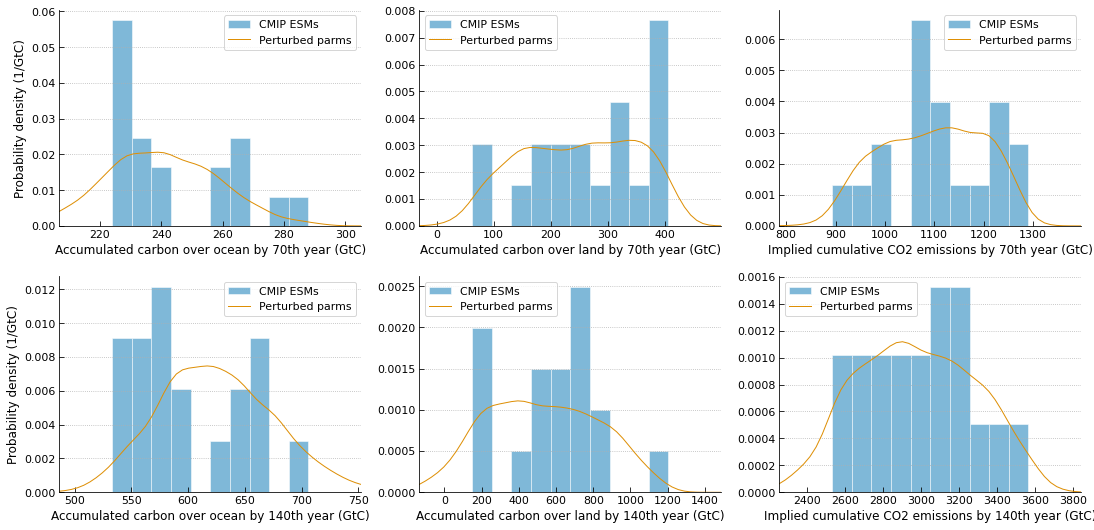

In [39]:
# Comparison between the sampled and CMIP ensembles

names = [
    'coct|2x', 'cbst|2x', 'ctot|2x',
    'coct|4x', 'cbst|4x', 'ctot|4x',
]
col = 3
myplt.init_regular(len(names), col=col)

for n, name in enumerate(names):
    ax = myplt(n)
    ax.hist(
        df_parms_cmip_esm[name], alpha=0.5, density=True, label='CMIP ESMs',
        edgecolor='w',
    )
    kde = scipy.stats.gaussian_kde(df_indicator[name])
    xlim = ax.get_xlim()
    xlim_ext = (
        xlim[0] - 0.2*(xlim[1]-xlim[0]),
        xlim[1] + 0.2*(xlim[1]-xlim[0]),
    )
    xval = np.linspace(*xlim_ext)
    ax.plot(xval, kde(xval), label='Perturbed parms')
    ax.legend()
    ax.set_xlim(*xlim_ext)
    ax.set_xlabel('{} ({})'.format(*names_indicator[name]))
    if n%col == 0:
        ax.set_ylabel('Probability density (1/GtC)')

    ax.grid(axis='y')

## 3. Constraining

In [40]:
# Target probability density function
# Here, CMIP land accumulated carbon in the 70th year is selected,
# to which a skewed normal distribution is fitted,
# as a single constraint

stat_model = StatModel()
name_target = 'cbst|2x'
constraints = {
    'very_likely__lower': df_parms_cmip_esm[name_target].quantile(0.05),
    'central': df_parms_cmip_esm[name_target].mean(),
    # consider mean value as median
    'very_likely__upper': df_parms_cmip_esm[name_target].quantile(0.95),
}
rv = stat_model.get_rv('skewnorm', constraints, a=0., loc=270., scale=50.)
name_target, rv.args, rv.kwds

('cbst|2x',
 (-2.7619833514351715,),
 {'loc': 373.3282785545086, 'scale': 155.62953259860817})

In [41]:
## Apply the MH sampler
obj_mh = SamplingMH(df_indicator[name_target], rv.pdf)
index1, index1a = obj_mh.sampling()
print('acceptance rate', len(index1a)/len(index1))

acceptance rate 0.831


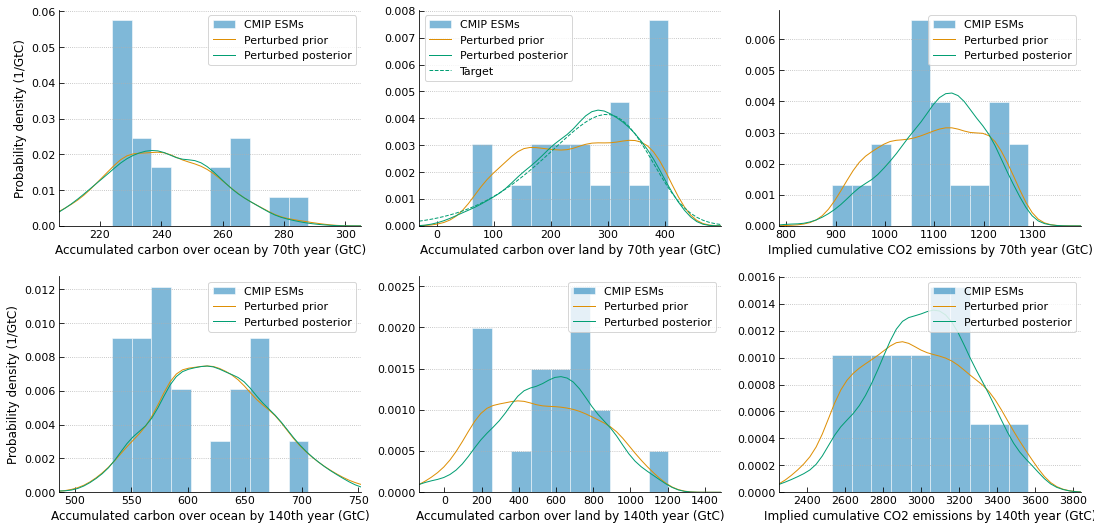

In [42]:
# Comparison between the sampled (prior) and constrained (posterior) ensembles

names = [
    'coct|2x', 'cbst|2x', 'ctot|2x',
    'coct|4x', 'cbst|4x', 'ctot|4x',
]
col = 3
myplt.init_regular(len(names), col=col)
for n, name in enumerate(names):
    ax = myplt(n)
    ax.hist(
        df_parms_cmip_esm[name], alpha=0.5, density=True, label='CMIP ESMs',
        edgecolor='w',
    )

    kde = scipy.stats.gaussian_kde(df_indicator[name])
    xlim = ax.get_xlim()
    xlim_ext = (
        xlim[0] - 0.2*(xlim[1]-xlim[0]),
        xlim[1] + 0.2*(xlim[1]-xlim[0]),
    )
    xval = np.linspace(*xlim_ext)
    ax.plot(xval, kde(xval), label='Perturbed prior')

    kde = scipy.stats.gaussian_kde(df_indicator.loc[index1, name])
    ax.plot(xval, kde(xval), label='Perturbed posterior')

    if name == name_target:
        ax.plot(xval, rv.pdf(xval), color='C2', ls='--', label='Target')

    ax.legend()
    ax.set_xlim(*xlim_ext)
    ax.set_xlabel('{} ({})'.format(*names_indicator[name]))
    if n%col == 0:
        ax.set_ylabel('Probability density (1/GtC)')

    ax.grid(axis='y')

In [43]:
# Additional indicators for diagnostics

for dfx in [df_parms_cmip_esm, df_indicator]:
    dfx['coct+cbst|2x'] = dfx['coct|2x'] + dfx['cbst|2x']
    dfx['coct+cbst|4x'] = dfx['coct|4x'] + dfx['cbst|4x']
    dfx['coct_ratio|2x'] = dfx['coct|2x'] / dfx['coct+cbst|2x']
    dfx['coct_ratio|4x'] = dfx['coct|4x'] / dfx['coct+cbst|4x']

names_indicator.update({
    'coct+cbst|2x':
    ('Total accumulated carbon by 70th year', 'GtC'),
    'coct+cbst|4x':
    ('Total accumulated carbon by 140th year', 'GtC'),
    'coct_ratio|2x':
    (
        'Ratio of accumulated carbon over ocean by 70th year',
        'dimensionless',
    ),
    'coct_ratio|4x': (
        'Ratio of accumulated carbon over ocean by 140th year',
        'dimensionless',
    ),
})    

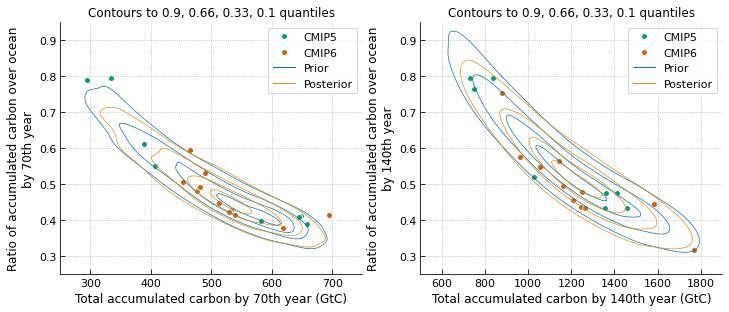

In [45]:
# Characteristic relationships associated with carbon cycle

map_lim = {
    'coct+cbst|2x': (250., 750.),
    'coct+cbst|4x': (500., 1900.),
    'coct_ratio|2x': (0.25, 0.95),
    'coct_ratio|4x': (0.25, 0.95),
}
map_colors = {
    'cmip5': 'C2',
    'cmip6': 'C3',
}
kw_plot_cmip = {'ls': 'None', 'marker': 'o', 'mec': 'w'}
prob_ref = np.array([0.90, 0.66, 0.33, 0.1])

myplt.init_regular(2, col=2, kw_space={'height': 3.5, 'aspect': 1.2})

for n, (xvar, yvar) in enumerate([
    ('coct+cbst|2x', 'coct_ratio|2x'),
    ('coct+cbst|4x', 'coct_ratio|4x'),
]):
    ax = myplt(n)
    for mip, df in df_parms_cmip_esm.groupby('mip'):
        ax.plot(
            df[xvar].values, df[yvar].values, color=map_colors[mip],
            label=mip.upper(), **kw_plot_cmip,
        )

    handles, labels = ax.get_legend_handles_labels()
    xlim = map_lim[xvar]
    ylim = map_lim[yvar]
    xp, yp = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
    positions = np.vstack([xp.ravel(), yp.ravel()])

    din = df_indicator.loc[:, [xvar, yvar]].T.values
    pdf = scipy.stats.gaussian_kde(din)
    zp = pdf(positions).reshape(xp.shape)
    levels = np.quantile(pdf(din), 1.-prob_ref)
    ax.contour(xp, yp, zp, levels, colors='C0', linewidths=0.7)
    handles.append(mpl.lines.Line2D([], [], color='C0'))
    labels.append('Prior')

    din = df_indicator.loc[index1, [xvar, yvar]].T.values
    pdf = scipy.stats.gaussian_kde(din)
    zp = pdf(positions).reshape(xp.shape)
    levels = np.quantile(pdf(din), 1.-prob_ref)
    ax.contour(xp, yp, zp, levels, colors='C1', linewidths=0.7)
    handles.append(mpl.lines.Line2D([], [], color='C1'))
    labels.append('Posterior')

    ax.legend(handles, labels)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    xlabel = '{} ({})'.format(*names_indicator[xvar])
    ax.set_xlabel(xlabel)
    ylabel = names_indicator[yvar][0]
    ax.set_ylabel('\n'.join(textwrap.wrap(ylabel, 40)))
    ax.set_title(
        'Contours to {} quantiles'.format(
            ', '.join([f'{x}' for x in prob_ref])
        ),
    )
    ax.grid()